obl 975


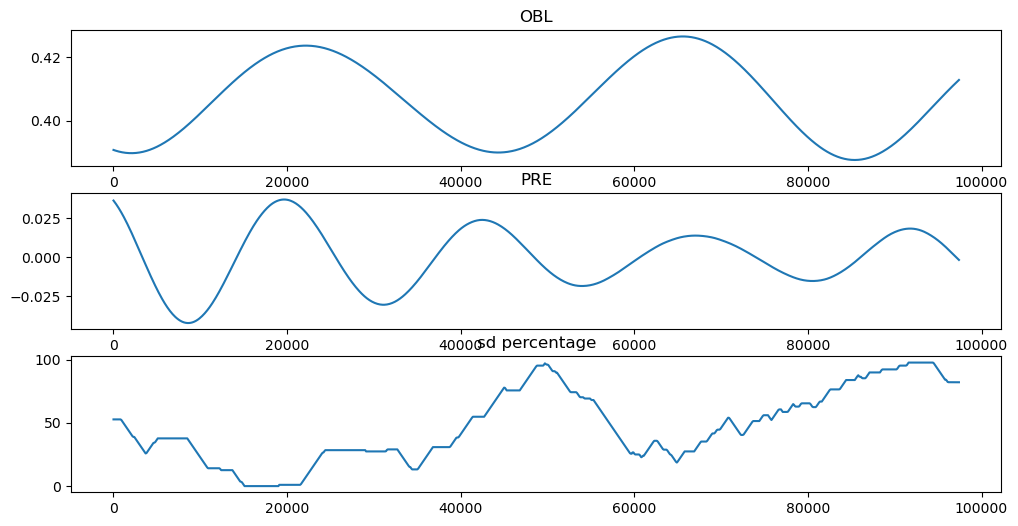

In [40]:
# read csv data
import pandas as pd
df_obl = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_long.csv")
df_pre = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_long.csv")
df_sd = pd.read_csv("output/df_stadial_duration_SlidingWindow.csv")

# plot data using 3 by 1 subplots
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(df_obl["age"], df_obl["obl"], label="obl")
ax[0].set_title("OBL")
ax[1].plot(df_pre["age"], df_pre["pre"], label="pre")
ax[1].set_title("PRE")
ax[2].plot(df_sd["age"], df_sd["percentage"], label="stages")
ax[2].set_title("sd percentage")

# print the length of the data
print("obl", len(df_obl))

In [41]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension

ages = df_pre["age"]


df_tmp = pd.DataFrame({
    "Time": ages,
    "pre": df_pre["pre"],  # predictor
    "sd": df_sd['percentage']          # target to predict
})

# We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
RhoMatrix = np.zeros((5, 20))

# For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
for tau in range(1, 21):
    edm_out = EmbedDimension(
        dataFrame=df_tmp,
        columns="sd",
        target="pre",
        maxE=5,          # We'll evaluate E=1..5
        tau=tau,
        Tp=0,
        lib="1 975",     # Entire time series, adapt if needed
        pred="1 975",
        showPlot=False,  # We'll handle plotting ourselves
    )

    for e_row in edm_out.itertuples():
        e_val = e_row.E     # 1..5
        rho_val = e_row.rho
        RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

# Axis values for plotting
E_axis = np.arange(1, 6)     # E = 1..5
Tau_axis = np.arange(1, 21)  # tau = 1..10


fig = go.Figure(data=[go.Surface(z=RhoMatrix, x=Tau_axis, y=E_axis)])

# Update the layout for better clarity.
fig.update_layout(
    title='Interactive 3D Surface: Rho vs E and tau',
    scene=dict(
        xaxis_title='tau',
        yaxis_title='E',
        zaxis_title='rho',
    ),
    autosize=True,
)

fig.show()

# E=4, tau=10


   LibSize       X:Y       Y:X
0    100.0  0.820309  0.739344
1    200.0  0.908826  0.851707
2    300.0  0.938019  0.896376
3    400.0  0.960667  0.922462
4    500.0  0.971439  0.937203
5    600.0  0.979043  0.947850
6    700.0  0.983657  0.953798
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


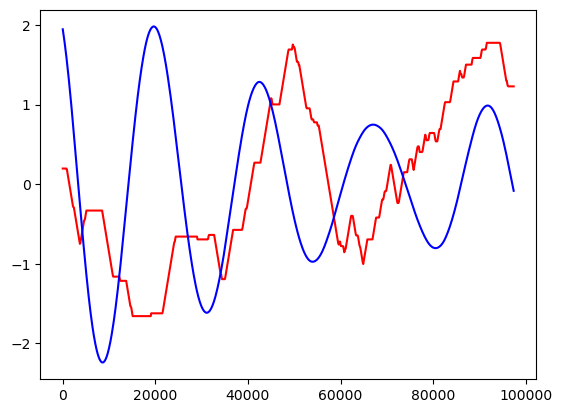

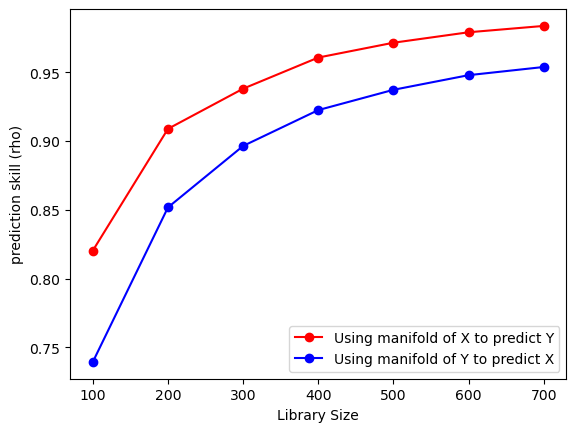

In [43]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt
from scipy.stats import zscore


ages = df_pre["age"]

df = pd.DataFrame({
    "Time": ages,
    "X": df_sd['percentage'],
    "Y":  df_pre["pre"]         # target to predict
})


# plot df
fig, ax = plt.subplots()
plt.plot(df['Time'], zscore(df['X']), 'r-')
plt.plot(df['Time'], zscore(df['Y']), 'b-')



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 4,
    tau         = 8,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 20,
    random      = True,
    replacement = False,
    Tp          = 0
)

print(ccm_out)
print("Columns:", ccm_out.columns)

fig, ax = plt.subplots()
# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Using manifold of X to predict Y')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Using manifold of Y to predict X')
plt.xlabel("Library Size")
plt.ylabel('prediction skill (rho)')
plt.legend()
plt.show()

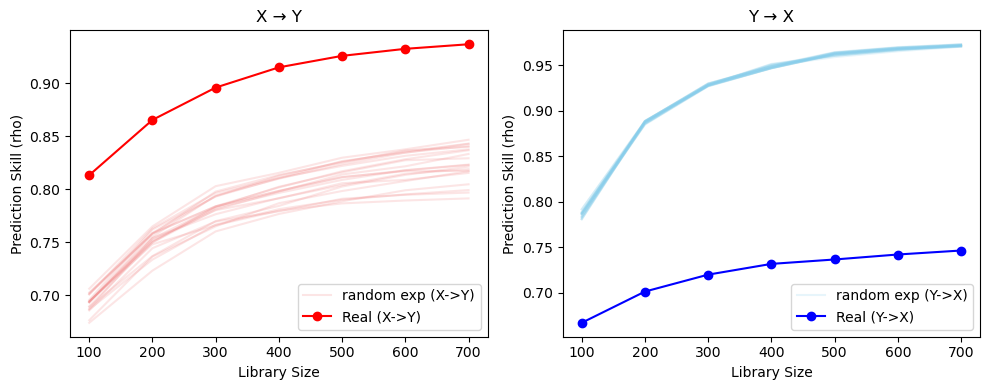

In [49]:
def randomize_stadial(stadial_data, fraction=0.1, seed=None):
    """
    1) Multiply original data by (1 + random variation in [-fraction, fraction]).
    2) Chop in half and rejoin (destroys original time ordering).
    """
    if seed is not None:
        np.random.seed(seed)
    
    N = len(stadial_data)
    # 1. Vary by ± fraction
    variation = 1.0 + fraction * (2*np.random.rand(N) - 1.0)  # e.g., ±10%
    randomized = stadial_data * variation
    
    # 2. Chop and rejoin
    half = N // 2
    randomized_swapped = np.concatenate([randomized[half:], randomized[:half]])
    
    return randomized_swapped


df = pd.DataFrame({
    "Time": ages,
    "X": df_sd['percentage'],
    "Y":  df_pre["pre"]         # target to predict
})


# Number of surrogate draws
n_ran = 20

# Storage for surrogates
ran_ccm_list_xy = []  # for X->Y direction


lib_sizes = "100 200 300 400 500 600 700"

for i in range(n_ran):
    # 1) Generate random surrogate stadial data
    X_ran = randomize_stadial(df['X'].values, fraction=0.1)
    
    # 2) Create DataFrame with the *same* Y (precession) but newly randomized X
    df_surr = pd.DataFrame({
        'Time': df['Time'],
        'X': X_ran,
        'Y': df['Y'].values
    })
    
    # 3) Run CCM for X->Y
    out_xy = CCM(
        dataFrame   = df_surr,
        E           = 4,
        tau         = 8,
        columns     = "X",
        target      = "Y",
        libSizes    = lib_sizes,
        sample      = 20,
        random      = True,
        replacement = False,
        Tp          = 0
    )
    ran_ccm_list_xy.append(out_xy)
    


import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# 1) X->Y subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    # Surrogate lines (fade them in background)
    label_xy = "random exp (X->Y)" if i == 0 else None
    ax1.plot(out_xy['LibSize'], out_xy['X:Y'], color='lightcoral', alpha=0.2, label=label_xy)

# Overlay the real data CCM
ax1.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Real (X->Y)')
ax1.set_title("X → Y")
ax1.set_xlabel("Library Size")
ax1.set_ylabel("Prediction Skill (rho)")
ax1.legend()

# 2) Y->X subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    label_yx = "random exp (Y->X)" if i == 0 else None
    ax2.plot(out_xy['LibSize'], out_xy['Y:X'], color='skyblue', alpha=0.2, label=label_yx)

# Overlay the real data CCM
ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Real (Y->X)')
ax2.set_title("Y → X")
ax2.set_xlabel("Library Size")
ax2.set_ylabel("Prediction Skill (rho)")
ax2.legend()

plt.tight_layout()
plt.show()




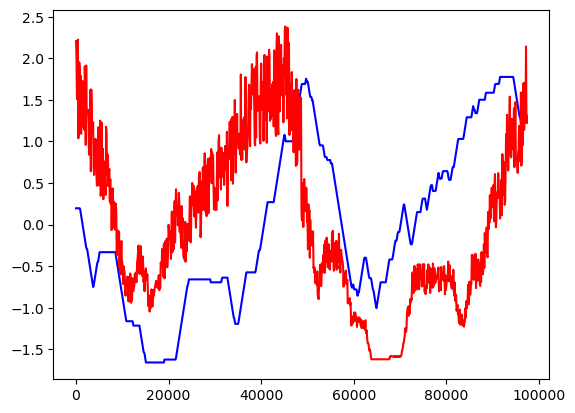

In [46]:
X_ran = randomize_stadial(df['X'].values, fraction=0.2)

# plot X_ran
fig, ax = plt.subplots()
plt.plot(df['Time'], zscore(df['X']), 'b-')
plt.plot(df['Time'], zscore(X_ran), 'r-')

   LibSize       X:Y       Y:X
0    100.0  0.813198  0.667264
1    200.0  0.865336  0.701560
2    300.0  0.895862  0.720145
3    400.0  0.914950  0.731940
4    500.0  0.925795  0.736770
5    600.0  0.932435  0.742239
6    700.0  0.936741  0.746615
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


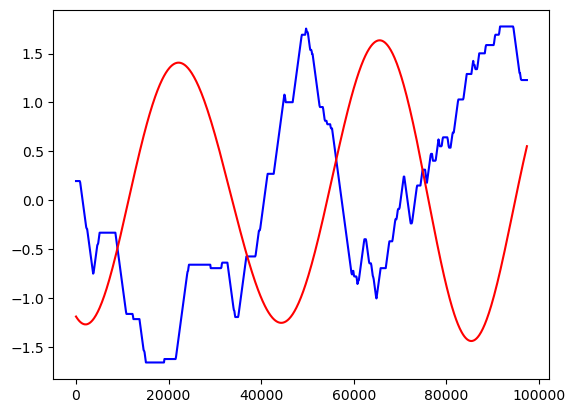

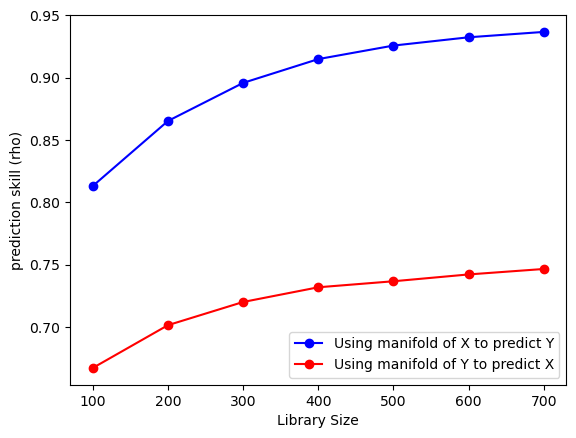

In [47]:
import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt
from scipy.stats import zscore




df = pd.DataFrame({
    "Time": ages,
    "X": df_sd['percentage'],
    "Y":  df_obl["obl"]         # target to predict
})




# plot df
fig, ax = plt.subplots()
plt.plot(df['Time'], zscore(df['X']), 'b-')
plt.plot(df['Time'], zscore(df['Y']), 'r-')



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 4,
    tau         = 10,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 0
)

print(ccm_out)
print("Columns:", ccm_out.columns)

fig, ax = plt.subplots()
# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Using manifold of X to predict Y')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='Using manifold of Y to predict X')
plt.xlabel("Library Size")
plt.ylabel('prediction skill (rho)')
plt.legend()
plt.show()

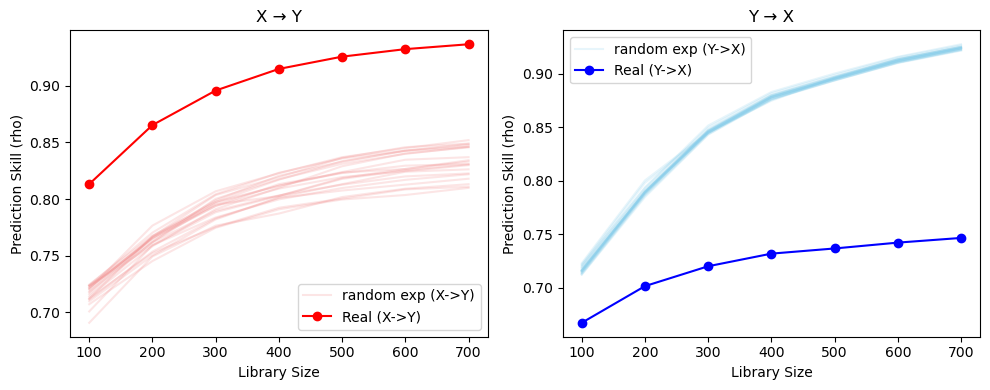

In [50]:
def randomize_stadial(stadial_data, fraction=0.1, seed=None):
    """
    1) Multiply original data by (1 + random variation in [-fraction, fraction]).
    2) Chop in half and rejoin (destroys original time ordering).
    """
    if seed is not None:
        np.random.seed(seed)
    
    N = len(stadial_data)
    # 1. Vary by ± fraction
    variation = 1.0 + fraction * (2*np.random.rand(N) - 1.0)  # e.g., ±10%
    randomized = stadial_data * variation
    
    # 2. Chop and rejoin
    half = N // 2
    randomized_swapped = np.concatenate([randomized[half:], randomized[:half]])
    
    return randomized_swapped


df = pd.DataFrame({
    "Time": ages,
    "X": df_sd['percentage'],
    "Y":  df_obl["obl"]         # target to predict
})


# Number of surrogate draws
n_ran = 20

# Storage for surrogates
ran_ccm_list_xy = []  # for X->Y direction


lib_sizes = "100 200 300 400 500 600 700"

for i in range(n_ran):
    # 1) Generate random surrogate stadial data
    X_ran = randomize_stadial(df['X'].values, fraction=0.1)
    
    # 2) Create DataFrame with the *same* Y (precession) but newly randomized X
    df_surr = pd.DataFrame({
        'Time': df['Time'],
        'X': X_ran,
        'Y': df['Y'].values
    })
    
    # 3) Run CCM for X->Y
    out_xy = CCM(
        dataFrame   = df_surr,
        E           = 4,
        tau         = 8,
        columns     = "X",
        target      = "Y",
        libSizes    = lib_sizes,
        sample      = 20,
        random      = True,
        replacement = False,
        Tp          = 0
    )
    ran_ccm_list_xy.append(out_xy)
    


import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# 1) X->Y subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    # Surrogate lines (fade them in background)
    label_xy = "random exp (X->Y)" if i == 0 else None
    ax1.plot(out_xy['LibSize'], out_xy['X:Y'], color='lightcoral', alpha=0.2, label=label_xy)

# Overlay the real data CCM
ax1.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Real (X->Y)')
ax1.set_title("X → Y")
ax1.set_xlabel("Library Size")
ax1.set_ylabel("Prediction Skill (rho)")
ax1.legend()

# 2) Y->X subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    label_yx = "random exp (Y->X)" if i == 0 else None
    ax2.plot(out_xy['LibSize'], out_xy['Y:X'], color='skyblue', alpha=0.2, label=label_yx)

# Overlay the real data CCM
ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Real (Y->X)')
ax2.set_title("Y → X")
ax2.set_xlabel("Library Size")
ax2.set_ylabel("Prediction Skill (rho)")
ax2.legend()

plt.tight_layout()
plt.show()


